In [1]:
import tensorflow as tf
import os
import numpy as np
from matplotlib import pyplot as plt
import IPython

from utils import utils
from dataset_generator import DatasetGenerator

os.chdir('../..') 

2023-04-28 22:56:55.428663: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-28 22:56:56.247503: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
train_dfs, val_dfs, test_dfs = utils.load_and_setup_data()

column_indices = {name: i for i, name in enumerate(train_dfs[0].columns)}

argument in operation 'asof_join' is not explicitly sorted

- If your data is ALREADY sorted, set the sorted flag with: '.set_sorted()'.
- If your data is NOT sorted, sort the 'expr/series/column' first.

This might become an error in a future version.
    
argument in operation 'asof_join' is not explicitly sorted

- If your data is ALREADY sorted, set the sorted flag with: '.set_sorted()'.
- If your data is NOT sorted, sort the 'expr/series/column' first.

This might become an error in a future version.
    
argument in operation 'asof_join' is not explicitly sorted

- If your data is ALREADY sorted, set the sorted flag with: '.set_sorted()'.
- If your data is NOT sorted, sort the 'expr/series/column' first.

This might become an error in a future version.
    
argument in operation 'asof_join' is not explicitly sorted

- If your data is ALREADY sorted, set the sorted flag with: '.set_sorted()'.
- If your data is NOT sorted, sort the 'expr/series/column' first.

This might become an 

In [3]:
label_columns = ['Adj Close']

single_step_window = DatasetGenerator(train_dfs, val_dfs, test_dfs, 1, 1, 1, label_columns)

wide_window = DatasetGenerator(train_dfs, val_dfs, test_dfs,  20, 20, 1, label_columns)

CONV_WIDTH = 3
conv_window = DatasetGenerator(train_dfs, val_dfs, test_dfs, CONV_WIDTH, 1, 1, label_columns)

LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = DatasetGenerator(train_dfs, val_dfs, test_dfs, INPUT_WIDTH, LABEL_WIDTH, 1, label_columns)

2023-04-28 22:56:57.479975: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-28 22:56:57.506972: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-28 22:56:57.507185: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

### Zero Predictor

In [4]:
class Zero(tf.keras.Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index

    def call(self, inputs):
        if self.label_index is None:
            return inputs
        result = inputs[:, :, self.label_index]
        result = result[:, :, tf.newaxis]
        
        return tf.zeros_like(result, tf.int32)
                    

In [5]:
zero = Zero(label_index=column_indices['Adj Close'])

zero.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Zero'] = zero.evaluate(single_step_window.val)
performance['Zero'] = zero.evaluate(single_step_window.test, verbose=0)

2023-04-28 22:57:03.806707: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_31' with dtype double and shape [562,17]
	 [[{{node Placeholder/_31}}]]
2023-04-28 22:57:03.809670: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_319' with dtype double and shape [562,17]
	 [[{{node Placeholder/_319}}]]


196/196 [==============================] - 1s 2ms/step - loss: 0.7032 - mean_absolute_error: 0.8702


2023-04-28 22:57:04.590341: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_108' with dtype int32
	 [[{{node Placeholder/_108}}]]
2023-04-28 22:57:04.592165: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_300' with dtype int32
	 [[{{node Placeholder/_300}}]]


2023-04-28 22:57:05.115235: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [1944]
	 [[{{node Placeholder/_8}}]]
2023-04-28 22:57:05.115696: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [1944]
	 [[{{node Placeholder/_8}}]]


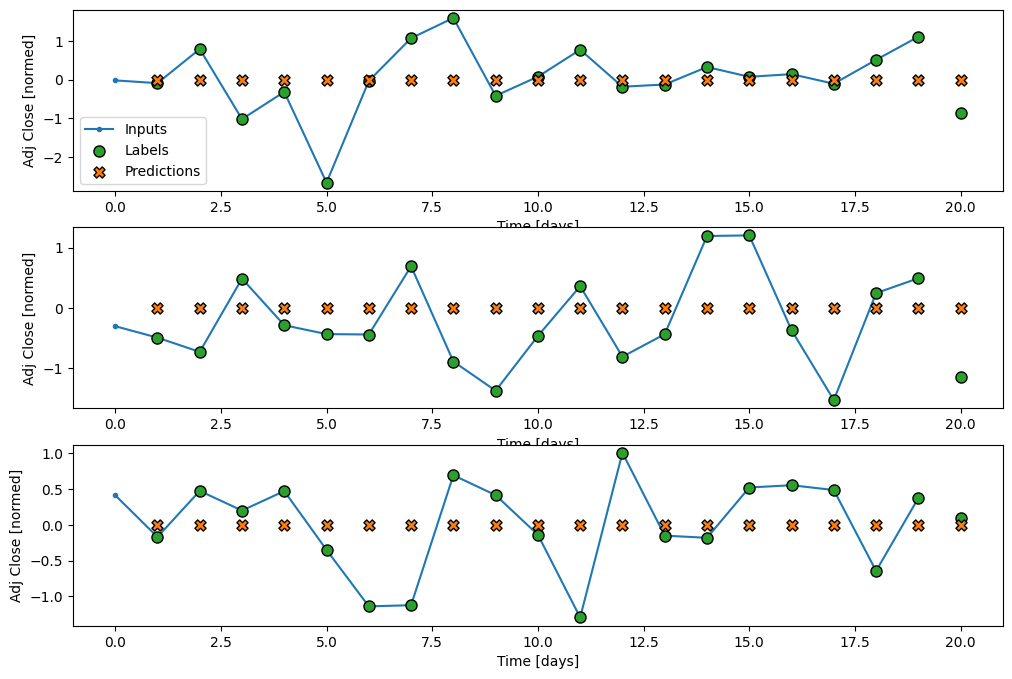

In [6]:
wide_window.windows[0].plot(zero)

### Baseline

In [7]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]


In [8]:
baseline = Baseline(label_index=column_indices['Adj Close'])

baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanAbsoluteError()])

val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)


196/196 [==============================] - 1s 2ms/step - loss: 4.0098 - mean_absolute_error: 1.3159


In [9]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

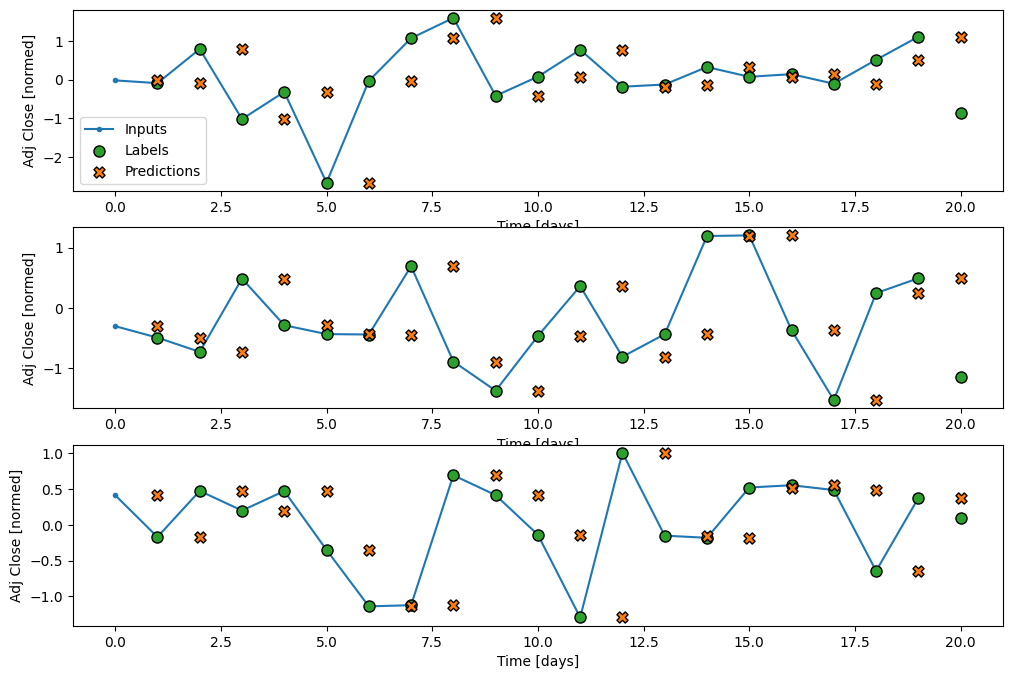

In [10]:
wide_window.windows[0].plot(baseline)

### Linear

In [11]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [12]:
history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/20


2023-04-28 22:57:08.733495: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_205' with dtype int32
	 [[{{node Placeholder/_205}}]]
2023-04-28 22:57:08.737933: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_333' with dtype int32
	 [[{{node Placeholder/_333}}]]
2023-04-28 22:57:10.531081: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x27344b50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-04-28 22:57:10.531107: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce GTX 1650, Compute Capability 

678/678 [==============================] - 6s 5ms/step - loss: 1.9087 - mean_absolute_error: 0.9865 - val_loss: 2.2604 - val_mean_absolute_error: 1.0131
Epoch 2/20
678/678 [==============================] - 2s 3ms/step - loss: 1.0624 - mean_absolute_error: 0.7223 - val_loss: 1.9352 - val_mean_absolute_error: 0.9098
Epoch 3/20
678/678 [==============================] - 2s 3ms/step - loss: 1.0208 - mean_absolute_error: 0.7047 - val_loss: 1.8841 - val_mean_absolute_error: 0.8961
Epoch 4/20
678/678 [==============================] - 2s 3ms/step - loss: 1.0119 - mean_absolute_error: 0.7006 - val_loss: 1.8598 - val_mean_absolute_error: 0.8895
Epoch 5/20
678/678 [==============================] - 2s 3ms/step - loss: 1.0076 - mean_absolute_error: 0.6986 - val_loss: 1.8446 - val_mean_absolute_error: 0.8849
Epoch 6/20
678/678 [==============================] - 2s 3ms/step - loss: 1.0049 - mean_absolute_error: 0.6973 - val_loss: 1.8418 - val_mean_absolute_error: 0.8844
Epoch 7/20
678/678 [=======

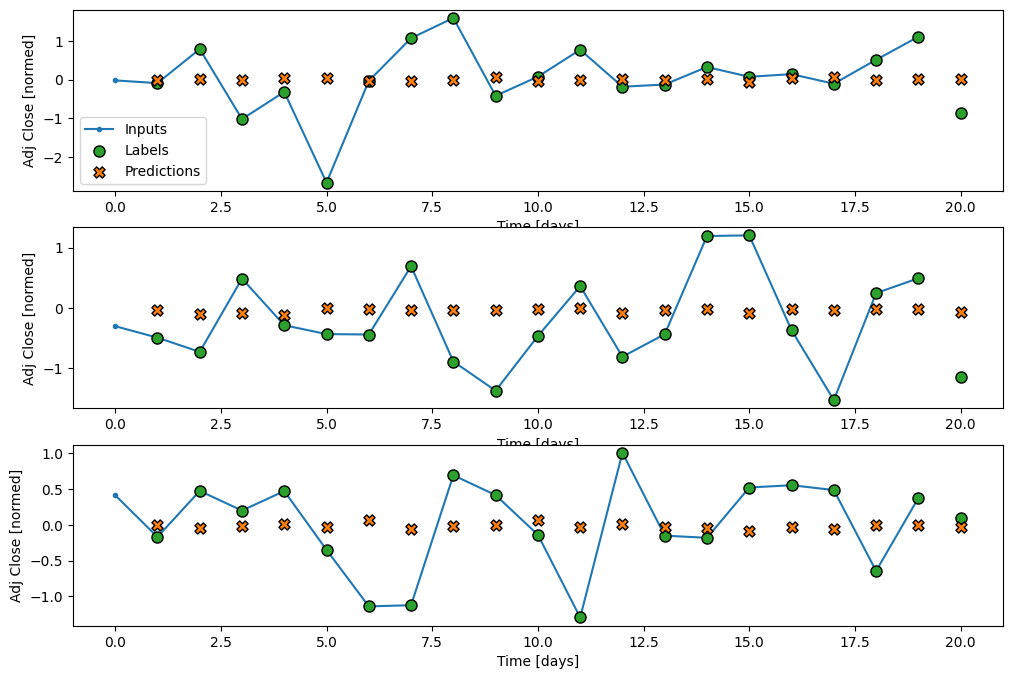

In [13]:
wide_window.windows[0].plot(linear)

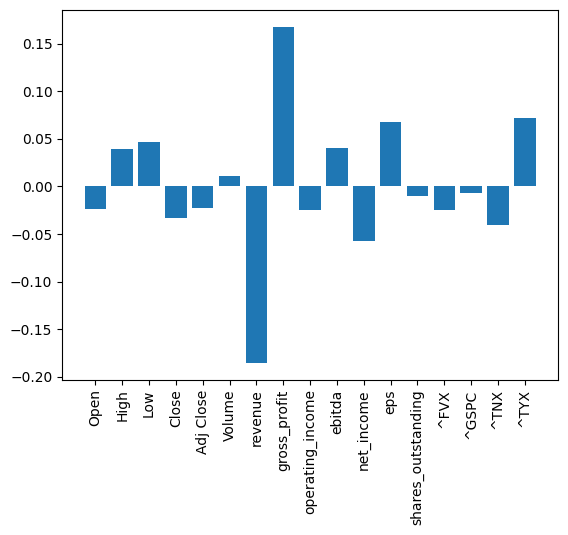

In [14]:
plt.bar(x = range(len(train_dfs[0].columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_dfs[0].columns)))
_ = axis.set_xticklabels(train_dfs[0].columns, rotation=90)

### Dense

In [15]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
678/678 [==============================] - 4s 4ms/step - loss: 1.0097 - mean_absolute_error: 0.6993 - val_loss: 1.8577 - val_mean_absolute_error: 0.8892
Epoch 2/20
678/678 [==============================] - 3s 4ms/step - loss: 0.9904 - mean_absolute_error: 0.6925 - val_loss: 1.9154 - val_mean_absolute_error: 0.9149
Epoch 3/20
196/196 [==============================] - 1s 3ms/step - loss: 1.8597 - mean_absolute_error: 0.8925


### Multi-step Dense

In [16]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])


In [17]:
history = compile_and_fit(multi_step_dense, conv_window)

IPython.display.clear_output()
val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0)

196/196 [==============================] - 1s 3ms/step - loss: 1.9321 - mean_absolute_error: 0.9011


2023-04-28 22:58:03.665332: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_301' with dtype int32
	 [[{{node Placeholder/_301}}]]
2023-04-28 22:58:03.668483: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_173' with dtype int32
	 [[{{node Placeholder/_173}}]]


2023-04-28 22:58:04.188757: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [1964,17]
	 [[{{node Placeholder/_0}}]]
2023-04-28 22:58:04.189565: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [1964,17]
	 [[{{node Placeholder/_0}}]]


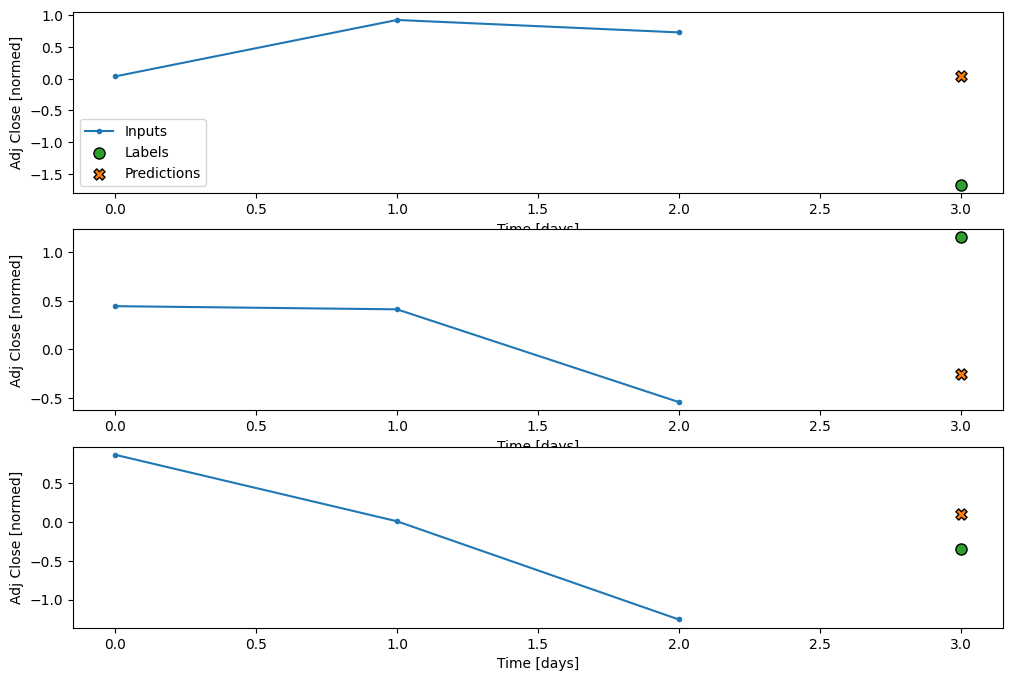

In [18]:
conv_window.windows[0].plot(multi_step_dense)

### Convolutional Neural Network

In [19]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

In [20]:
history = compile_and_fit(conv_model, conv_window)

IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)

196/196 [==============================] - 1s 3ms/step - loss: 1.9648 - mean_absolute_error: 0.9336


2023-04-28 22:58:17.601729: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [1938]
	 [[{{node Placeholder/_8}}]]
2023-04-28 22:58:17.602234: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [1938]
	 [[{{node Placeholder/_8}}]]


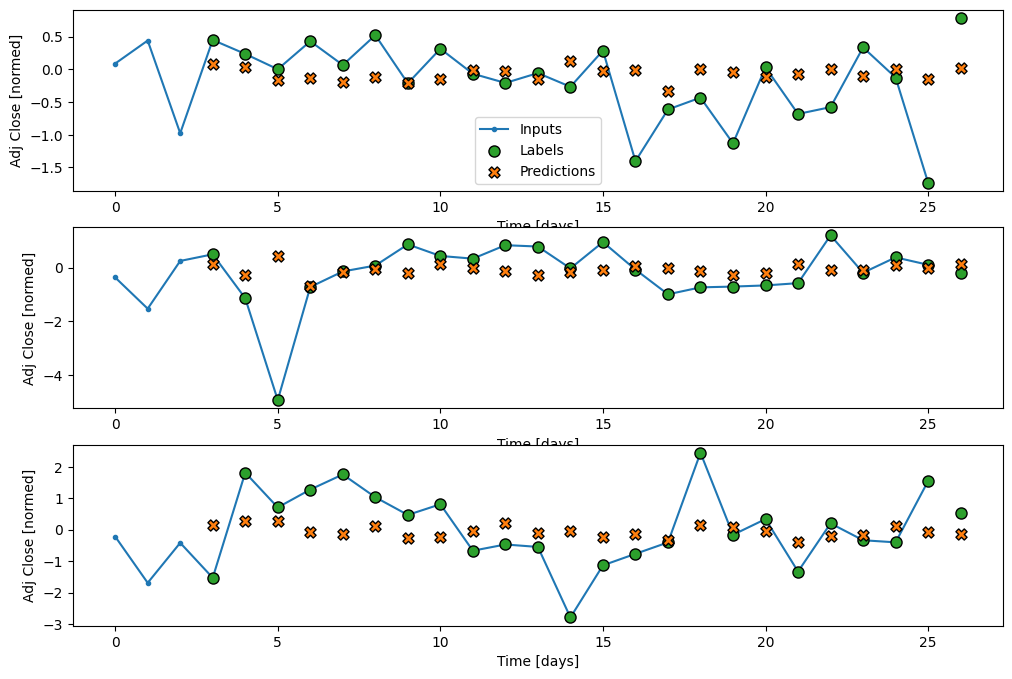

In [21]:
wide_conv_window.windows[0].plot(conv_model)

### LSTM

In [22]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(4, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [23]:
history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

188/188 [==============================] - 1s 3ms/step - loss: 1.8707 - mean_absolute_error: 0.8877


2023-04-28 22:58:32.728505: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_269' with dtype int32
	 [[{{node Placeholder/_269}}]]
2023-04-28 22:58:32.731147: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_127' with dtype double and shape [281,17]
	 [[{{node Placeholder/_127}}]]


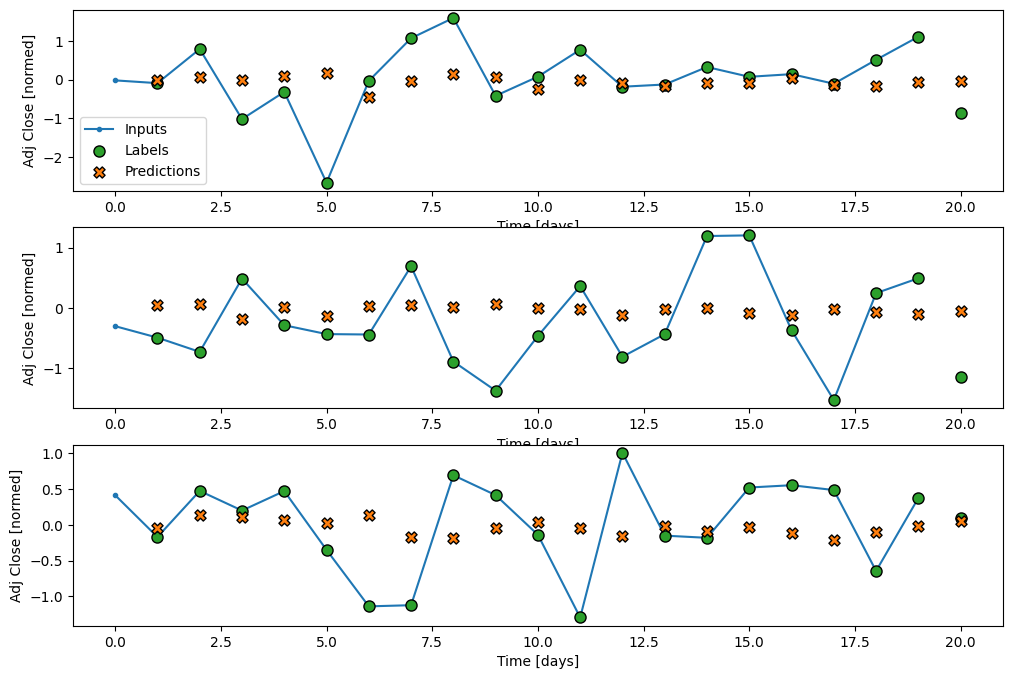

In [24]:
wide_window.windows[0].plot(lstm_model)

### Other LSTMs

In [25]:
lstm_model_2 = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, return_sequences=True),
    tf.keras.layers.Dense(units=1)
])

lstm_model_3 = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(16, return_sequences=True),
    tf.keras.layers.Dense(units=1)
])

lstm_model_4 = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(4, return_sequences=True),
    tf.keras.layers.LSTM(4, return_sequences=True),
    tf.keras.layers.Dense(units=1)
])

In [26]:
models = [lstm_model_2, lstm_model_3, lstm_model_4]
names = ["LSTM_2", "LSTM_3", "LSTM_4"]

for i, model in enumerate(models):
    history = compile_and_fit(model, wide_window)

    IPython.display.clear_output()
    val_performance[names[i]] = model.evaluate(wide_window.val)
    performance[names[i]] = model.evaluate(wide_window.test, verbose=0)

188/188 [==============================] - 1s 4ms/step - loss: 1.8585 - mean_absolute_error: 0.8792


## Performance

{'Zero': [0.6674289703369141, 1.1004935503005981], 'Baseline': [4.283662796020508, 1.590617060661316], 'Linear': [2.163975477218628, 1.1230614185333252], 'Dense': [2.132256031036377, 1.1156865358352661], 'Multi step dense': [2.1825950145721436, 1.1238694190979004], 'Conv': [2.661686897277832, 1.261780023574829], 'LSTM': [2.182051420211792, 1.1222760677337646], 'LSTM_2': [2.2086029052734375, 1.1329282522201538], 'LSTM_3': [2.2873916625976562, 1.153722882270813], 'LSTM_4': [2.174938678741455, 1.120705485343933]}


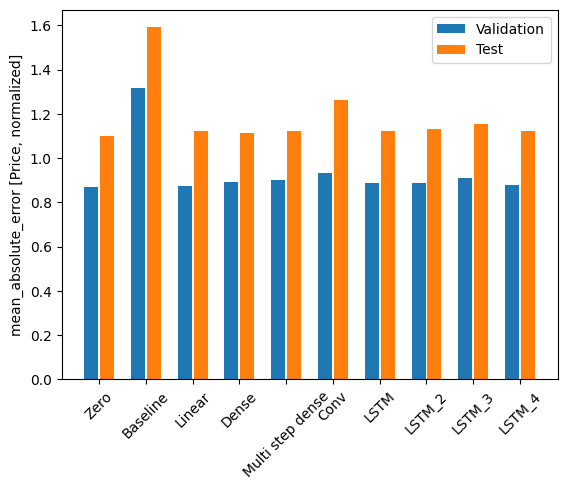

In [27]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [Price, normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

print(performance)
